# Direct Search Optimiser (unlabelled) Example

The Direct Search Optimiser module is used to optimise the thresholds of an existing set of rules, given an **unlabelled** dataset, using Direct Search-type Optimisation algorithms.

## Requirements

To run, you'll need the following:

* A rule set stored in the standard Iguanas lambda expression format, along with the keyword arguments for each lambda expression (more information on how to do this later)
* An unlabelled dataset containing the features present in the rule set.

----

## Import packages

In [1]:
from iguanas.rule_optimisation import DirectSearchOptimiser
from iguanas.rules import Rules
from iguanas.rule_application import RuleApplier
from iguanas.metrics.unsupervised import AlertsPerDay

import pandas as pd
from sklearn.model_selection import train_test_split

## Read in data

Firstly, we need to read in the raw data containing the features:

In [2]:
data = pd.read_csv(
    'dummy_data/dummy_pipeline_output_data.csv', 
    index_col='eid'
)

Then we can split the dataset into training and test sets:

In [3]:
X_train, X_test = train_test_split(
    data, 
    test_size=0.33, 
    random_state=0
)

## Read in the rules

In this example, we'll read in the rule conditions from a pickle file, where they are stored in the standard Iguanas string format. However, you can use any Iguanas-ready rule format - see the example notebook in the `rules` module.

In [4]:
import pickle
with open('dummy_data/rule_strings.pkl', 'rb') as f:
    rule_strings = pickle.load(f)

Now we can instantiate the `Rules` class with these rules:

In [5]:
rules = Rules(rule_strings=rule_strings)

We now need to convert the rules into the standard Iguanas lambda expression format. This format allows new threshold values to be injected into the rule condition before being evaluated - this is how the Bayesian Optimiser finds the optimal threshold values:

In [6]:
rule_lambdas = rules.as_rule_lambdas(
    as_numpy=False, 
    with_kwargs=True
)

By converting the rule conditions to the standard Iguanas lambda expression format, we also generate a dictionary which gives the keyword arguments to each lambda expression (this dictionary is saved as the class attribute `lambda_kwargs`). Using these keyword arguments as inputs to the lambda expressions will convert them into the standard Iguanas string format.

----

## Optimise rules

### Set up class parameters

Now we can set our class parameters for the Direct Search Optimiser. Here we're using the `fit` method from the `AlertsPerDay` class, which calculates the negative squared difference between the daily number of records a rule flags vs the targetted daily number of records flagged. This means that when the Direct Search Optimiser comes to maximise this metric, it will try to minimise the difference between the actual number of records flagged and the targetted number of records flagged.

See the `metrics.unsupervised` module for more information on additional optimisation functions that can be used on unlabelled datasets.

We're also using the `Nelder-Mead` algorithm, which often benefits from setting the optional `initial_simplex` parameter. This is set through the `options` keyword argument. Here, we'll generate the initial simplex of each rule using the `create_initial_simplexes` method (but you can create your own if required).

**Please see the class docstring for more information on each parameter.**

In [7]:
apd = AlertsPerDay(
    n_alerts_expected_per_day=10, 
    no_of_days_in_file=10
)

In [8]:
initial_simplexes = DirectSearchOptimiser.create_initial_simplexes(
    X=X_train, 
    lambda_kwargs=rules.lambda_kwargs, 
    shape='Minimum-based'
)

In [9]:
params = {
    'rule_lambdas': rule_lambdas,
    'lambda_kwargs': rules.lambda_kwargs,    
    'metric': apd.fit,
    'method': 'Nelder-Mead',
    'options': initial_simplexes,
    'verbose': 1,
}

### Instantiate class and run fit method

Once the parameters have been set, we can run the `fit` method to optimise the rules.

In [10]:
ro = DirectSearchOptimiser(**params)
X_rules = ro.fit(X=X_train)

--- Checking for rules with features that are missing in `X` ---
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 25534.05it/s]
--- Checking for rules that exclusively contain non-optimisable conditions ---
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 93097.87it/s]
--- Checking for rules that exclusively contain zero-variance features ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

### Outputs

The `fit` method returns a dataframe giving the binary columns of the optimised rules as applied to the training dataset. See the `Attributes` section in the class docstring for a description of each attribute generated:

In [11]:
X_rules.head()

,RGDT_Rule137,RGDT_Rule81,HighFraudTxnPerAccountNum,RGDT_Rule256,RGDT_Rule35,RGDT_Rule193,RGDT_Rule241,RGDT_Rule263,RGDT_Rule313,RGDT_Rule195,RGDT_Rule153,RGDT_Rule112,RGDT_Rule2,RGDT_Rule65,RGDT_Rule45,RGDT_Rule162,RGDT_Rule272,RGDT_Rule24,ComplicatedRule
eid,,,,,,,,,,,,,,,,,,,
503-0182982-0226911,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,1,0,0,0
516-2441570-6696110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
475-5982298-4197297,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
935-3613661-7862154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
936-1684183-4550418,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
ro.opt_rule_performances

{'RGDT_Rule137': -6.759999999999998,
 'RGDT_Rule81': -0.039999999999999716,
 'HighFraudTxnPerAccountNum': -57.76,
 'RGDT_Rule256': -13.690000000000001,
 'RGDT_Rule35': -24.010000000000005,
 'RGDT_Rule193': -25.0,
 'RGDT_Rule241': -0.0,
 'RGDT_Rule263': -30.25,
 'RGDT_Rule313': -0.6400000000000011,
 'RGDT_Rule195': -25.0,
 'RGDT_Rule153': -0.009999999999999929,
 'RGDT_Rule112': -67.24,
 'RGDT_Rule2': -70.56,
 'RGDT_Rule65': -0.009999999999999929,
 'RGDT_Rule45': -0.0,
 'RGDT_Rule162': -0.0,
 'RGDT_Rule272': -84.63999999999999,
 'RGDT_Rule24': -0.0,
 'ComplicatedRule': -0.0}

---

## Apply rules to a separate dataset

Use the `transform` method to apply the optimised rules to a separate dataset:

In [15]:
X_rules_applied = ro.transform(X=X_test)

### Outputs

The `transform` method returns a dataframe giving the binary columns of the rules as applied to the given dataset:

In [16]:
X_rules_applied.head()

,RGDT_Rule137,RGDT_Rule81,HighFraudTxnPerAccountNum,RGDT_Rule256,RGDT_Rule35,RGDT_Rule193,RGDT_Rule241,RGDT_Rule263,RGDT_Rule313,RGDT_Rule195,RGDT_Rule153,RGDT_Rule112,RGDT_Rule2,RGDT_Rule65,RGDT_Rule45,RGDT_Rule162,RGDT_Rule272,RGDT_Rule24,ComplicatedRule
eid,,,,,,,,,,,,,,,,,,,
533-3553708-0918604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
455-3498977-3144749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
585-6596459-3918216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
685-6642742-5806657,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
956-2823525-9957253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

## Plotting the performance uplift

We can visualise the performance uplift of the optimised rules using the `plot_performance_uplift` and `plot_performance_uplift_distribution` methods:

* `plot_performance_uplift`: Generates a scatterplot showing the performance of each rule before and after optimisation.
* `plot_performance_uplift_distribution`: Generates a boxplot showing the distribution of performance uplifts (original rules vs optimised rules).

### On the training set

To visualise the uplift on the training set, we can use the class attributes `orig_rule_performances` and `opt_rule_performances` in the plotting methods, as these were generated as part of the optimisation process:

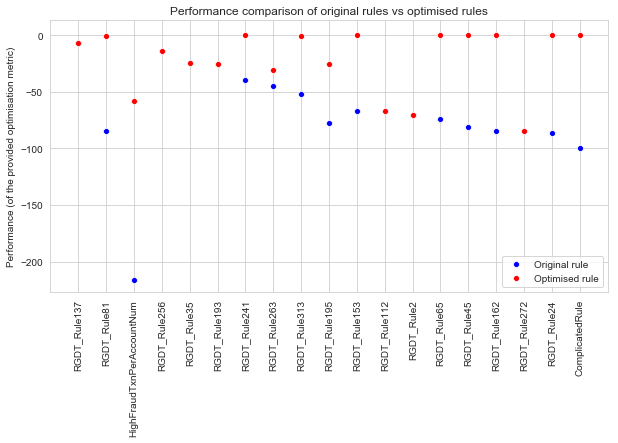

In [17]:
ro.plot_performance_uplift(
    orig_rule_performances=ro.orig_rule_performances,
    opt_rule_performances=ro.opt_rule_performances,
    figsize=(10, 5)
)

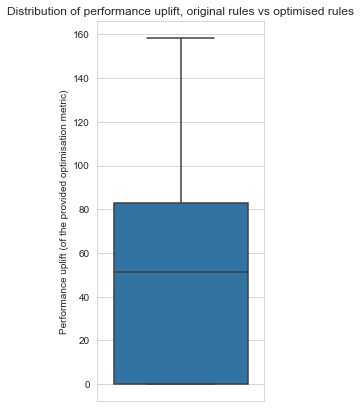

In [18]:
ro.plot_performance_uplift_distribution(
    orig_rule_performances=ro.orig_rule_performances,
    opt_rule_performances=ro.opt_rule_performances,
    figsize=(3, 7)
)

### On the test set

To visualise the uplift on the test set, we first need to generate the `orig_rule_performances` and `opt_rule_performances` parameters used in the plotting methods as these aren't created as part of the optimisation process. To do this, we need to apply both the original rules and the optimised rules to the test set. 

**Note:** before we apply the original rules, we need to remove those that either have no optimisable conditions, have zero variance features or have features that are missing in `X_train`:

In [19]:
# Original rules
rules_to_exclude = ro.rule_names_missing_features + ro.rule_names_no_opt_conditions + ro.rule_names_zero_var_features
rules.filter_rules(exclude=rules_to_exclude)
orig_X_rules = rules.transform(X_test)
orig_apds = apd.fit(orig_X_rules)
orig_rule_performances_test = dict(zip(orig_X_rules.columns.tolist(), orig_apds))

In [20]:
# Optimised rules
opt_X_rules = ro.transform(X_test)
opt_apds = apd.fit(opt_X_rules)
opt_rule_performances_test = dict(zip(opt_X_rules.columns.tolist(), opt_apds))

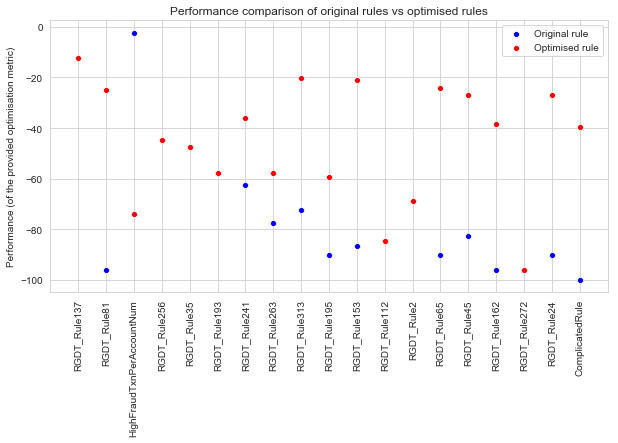

In [21]:
ro.plot_performance_uplift(
    orig_rule_performances=orig_rule_performances_test,
    opt_rule_performances=opt_rule_performances_test,
    figsize=(10, 5)
)

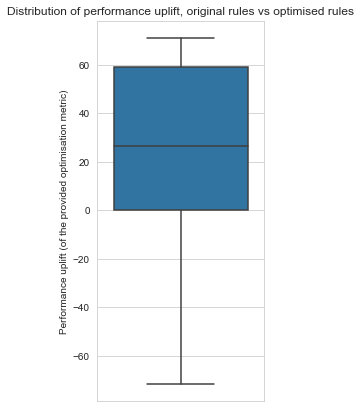

In [22]:
ro.plot_performance_uplift_distribution(
    orig_rule_performances=orig_rule_performances_test,
    opt_rule_performances=opt_rule_performances_test,
    figsize=(3, 7)
)

----